<a href="https://colab.research.google.com/github/chezyio/D7046E_Project/blob/main/D7046E_Retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D7046E Neural Networks and Learning Machines


# Import Libraries

In [1]:
!pip install snntorch
!pip install tonic
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [21]:
import tonic
import torch
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from collections import Counter
from tonic import transforms
from IPython.display import HTML
from snntorch import surrogate


## Dataset

In [3]:
# load train and test splits
train_set = tonic.datasets.DVSGesture(save_to='./data', train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', train=False)

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture


## Exploratory Data Analysis


(100, 2, 128, 128) 2


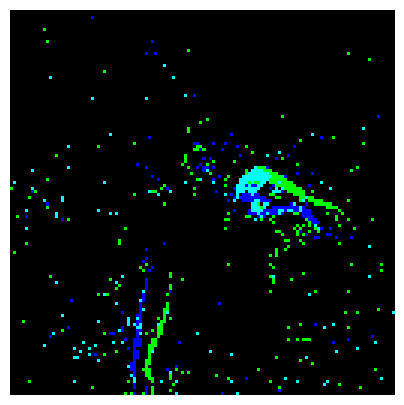

In [10]:
events, label = train_set[0]

to_frame = transforms.ToFrame(sensor_size=tonic.datasets.DVSGesture.sensor_size, n_time_bins=100)
frames = to_frame(events)

print(frames.shape, label)
animation = tonic.utils.plot_animation(frames)
HTML(animation.to_jshtml())

In [11]:
# basic info
print(f"Number of train samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")
print(f"Gesture categories: {train_set.classes}")

# inspect a single sample
sample_idx = 0
events, target = train_set[sample_idx]
print(f"Sample {sample_idx} - Target gesture: {train_set.classes[target]}")
print(f"Number of events in sample: {len(events)}")
print(f"Event attributes: {events.dtype.names}")

Number of train samples: 1077
Number of test samples: 264
Gesture categories: ['Hand clapping', 'Right hand wave', 'Left hand wave', 'Right arm cw', 'Right arm ccw', 'Left arm cw', 'Left arm ccw', 'Arm roll', 'Air drums', 'Air guitar', 'Other gestures']
Sample 0 - Target gesture: Left hand wave
Number of events in sample: 235550
Event attributes: ('x', 'y', 'p', 't')


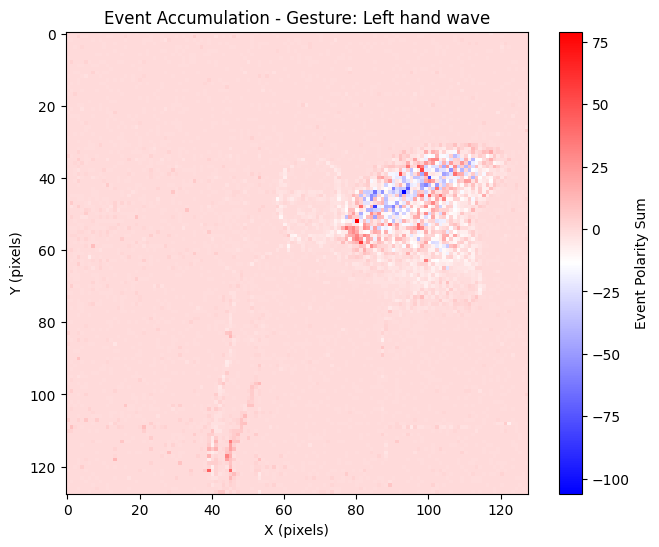

In [12]:
# visualize events for the first sample
events, target = train_set[0]

# convert events to a frame for visualization (accumulate events over time)
frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]), dtype=int)
for event in events:
    frame[event['y'], event['x']] += 1 if event['p'] else -1  # +ve/-ve polarity

plt.figure(figsize=(8, 6))
plt.imshow(frame, cmap='bwr', interpolation='nearest')
plt.title(f"Event Accumulation - Gesture: {train_set.classes[target]}")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label="Event Polarity Sum")
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


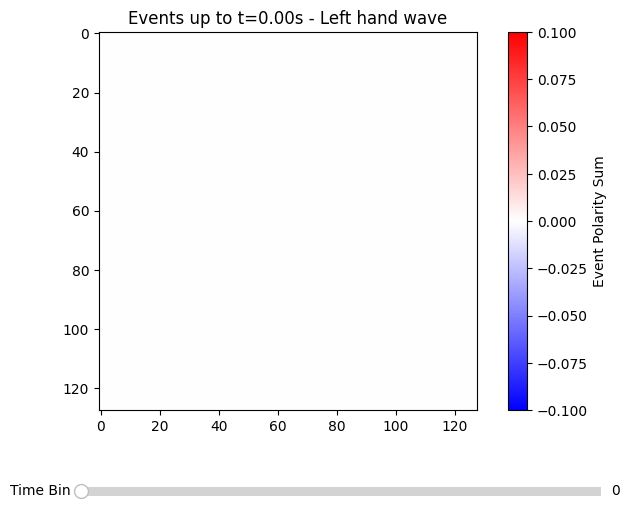

In [13]:
from matplotlib.widgets import Slider

events, target = train_set[0]
time_bins = np.linspace(events['t'].min(), events['t'].max(), 100)  # split into 100 time bins

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(bottom=0.25)
frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]))
initial_bin = 0
mask = (events['t'] < time_bins[initial_bin])
for event in events[mask]:
    frame[event['y'], event['x']] += 1 if event['p'] else -1
im = ax.imshow(frame, cmap='bwr', interpolation='nearest')
ax.set_title(f"Events up to t={time_bins[initial_bin]/1e6:.2f}s - {train_set.classes[target]}")
plt.colorbar(im, ax=ax, label="Event Polarity Sum")

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax_time, 'Time Bin', 0, len(time_bins)-1, valinit=initial_bin, valstep=1)

def update(val):
    bin_idx = int(time_slider.val)
    frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]))
    mask = (events['t'] < time_bins[bin_idx])
    for event in events[mask]:
        frame[event['y'], event['x']] += 1 if event['p'] else -1
    im.set_data(frame)
    ax.set_title(f"Events up to t={time_bins[bin_idx]/1e6:.2f}s - {train_set.classes[target]}")
    fig.canvas.draw_idle()

time_slider.on_changed(update)
plt.show()

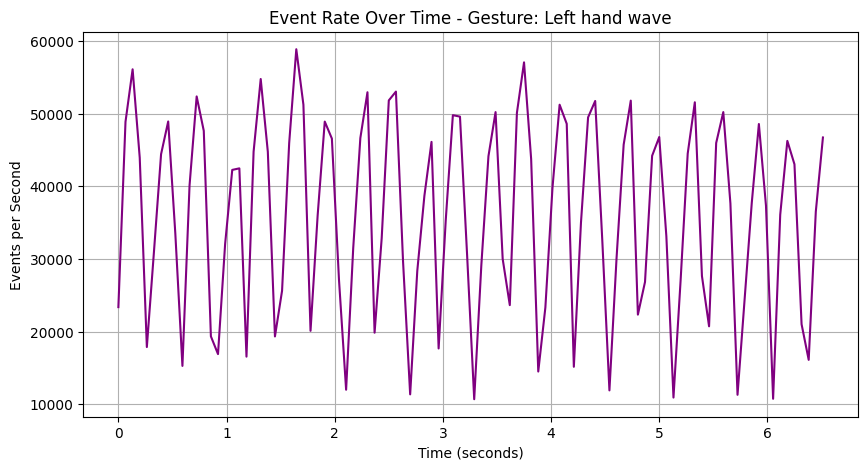

In [14]:
events, target = train_set[0]
times = events['t'] / 1e6
hist, bin_edges = np.histogram(times, bins=100)
event_rate = hist / np.diff(bin_edges)

plt.figure(figsize=(10, 5))
plt.plot(bin_edges[:-1], event_rate, color='purple')
plt.title(f"Event Rate Over Time - Gesture: {train_set.classes[target]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Events per Second")
plt.grid(True)
plt.show()

## Feature Engineering


In [15]:
transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000),
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(32, 32)),
    tonic.transforms.ToFrame(sensor_size=(32, 32, 2), n_time_bins=100),
])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=transforms, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=transforms, train=False)

cached_train_set = tonic.cached_dataset.DiskCachedDataset(train_set, cache_path='./cache/train')
cached_test_set = tonic.cached_dataset.DiskCachedDataset(test_set, cache_path='./cache/test')

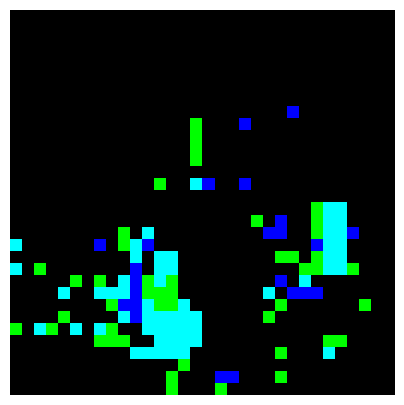

(100, 2, 32, 32) 9


In [16]:
from IPython.display import HTML

frames, label = cached_train_set[1]
animation = tonic.utils.plot_animation(frames)
print(frames.shape, label)
HTML(animation.to_jshtml())

In [17]:
from torch.utils.data import random_split

train_size = int(0.8 * len(cached_train_set))
val_size = len(cached_train_set) - train_size
train_set, val_set = random_split(cached_train_set, [train_size, val_size])

In [18]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True,
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_set, batch_size=32,shuffle=True, drop_last=True,
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(cached_test_set, batch_size=32, shuffle=True, drop_last=True,
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

## Model Training and Optimization

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
from snntorch import functional as SF

spike_grad = surrogate.atan()
beta = 0.5

net = nn.Sequential(
    nn.Conv2d(2, 12, 5), # in_channels, out_channels, kernel_size
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(800, 11), #800
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

loss_hist = []
acc_hist = []
val_acc_hist = []

In [24]:
def validate_model():
    correct, total = 0, 0
    for batch, (data, targets) in enumerate(iter(val_loader)):
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch]
        spk_rec = forward_pass(net, data)
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

In [25]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

In [28]:
num_epochs = 10
num_iters = 50

for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss.item())


        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        print(f"Epoch {epoch}, Iteration {batch} \nTrain Loss: {loss.item():.2f}")
        print(f"Train Accuracy: {acc * 100:.2f}%")
        val_acc = validate_model()
        val_acc_hist.append(val_acc)
        print(f"Validation Accuracy: {val_acc * 100:.2f}%\n")

        if batch == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 0.57
Train Accuracy: 100.00%
Validation Accuracy: 93.23%

Epoch 0, Iteration 1 
Train Loss: 0.86
Train Accuracy: 96.88%
Validation Accuracy: 91.67%

Epoch 0, Iteration 2 
Train Loss: 0.76
Train Accuracy: 100.00%
Validation Accuracy: 92.19%

Epoch 0, Iteration 3 
Train Loss: 0.85
Train Accuracy: 96.88%
Validation Accuracy: 93.23%

Epoch 0, Iteration 4 
Train Loss: 0.86
Train Accuracy: 100.00%
Validation Accuracy: 91.67%

Epoch 0, Iteration 5 
Train Loss: 1.01
Train Accuracy: 87.50%
Validation Accuracy: 91.67%

Epoch 0, Iteration 6 
Train Loss: 0.96
Train Accuracy: 96.88%
Validation Accuracy: 91.15%

Epoch 0, Iteration 7 
Train Loss: 1.08
Train Accuracy: 87.50%
Validation Accuracy: 90.62%

Epoch 0, Iteration 8 
Train Loss: 1.02
Train Accuracy: 90.62%
Validation Accuracy: 91.15%

Epoch 0, Iteration 9 
Train Loss: 0.73
Train Accuracy: 96.88%
Validation Accuracy: 91.15%

Epoch 0, Iteration 10 
Train Loss: 1.05
Train Accuracy: 93.75%
Validation Accuracy: 90.

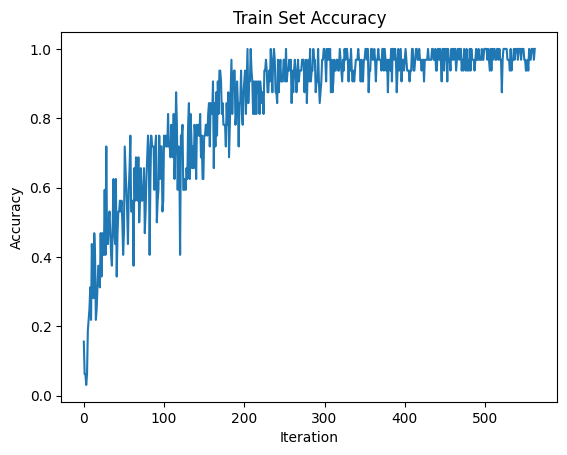

In [30]:
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

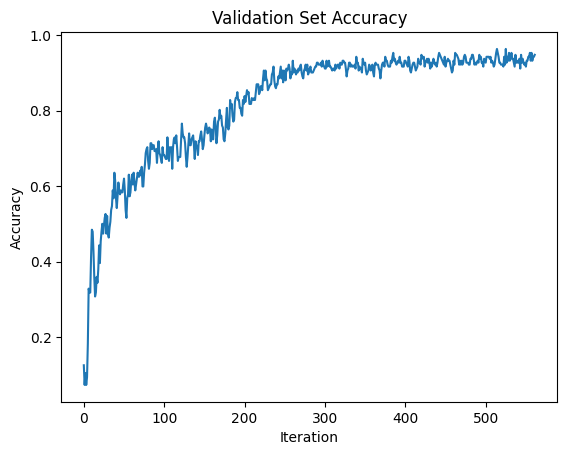

In [29]:
fig = plt.figure(facecolor="w")
plt.plot(val_acc_hist)
plt.title("Validation Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## Testing and Evaluation
Evaluate against unseen data (test set)...